In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 256
learing_rate = 0.0002
num_epoch = 10

In [3]:
#데이터 다운로드
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

#데이터로더 설정

train_loader = DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=2, drop_last=True)

100.0%


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



100.0%


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



100.0%


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



100.0%

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
            ),  # [batch_size,1,28,28] -> [batch_size,16,24,24]
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
            ),  # [batch_size,16,24,24] -> [batch_size,32,20,20]
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # [batch_size,32,20,20] -> [batch_size,32,10,10]
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=5,
            ),  # [batch_size,32,10,10] -> [batch_size,64,6,6]
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # [batch_size,64,6,6] -> [batch_size,64,3,3]
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 3 * 3, 100),  # [batch_size,64*3*3] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100, 10),  # [batch_size,100] -> [batch_size,10]
        )

    def forward(self, x):  # 전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류가 생긴다.
        out = self.layer(x)
        out = out.view(batch_size, -1)

        out = self.fc_layer(out)
        return out

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
# 손실함수 -> 교차엔트로피
loss_func = nn.CrossEntropyLoss()
# 최적화함수 -> Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

cuda:0


In [7]:
loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1583, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0847, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0237, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0527, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<NllLossBackward0>)


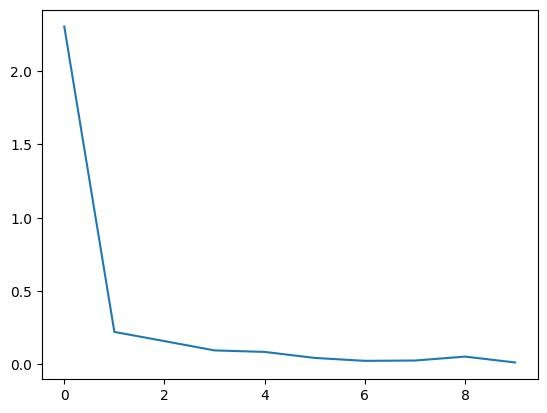

In [8]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()

In [10]:
correct = 0
total = 0

with torch.no_grad():
    for image, label in test_loader:
        x = image.to(device)
        y_ = label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻는다.
        output = model.forward(x)

        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아낸다.
        # 최대값은 필요없기에 _, 인덱스만 사용한다.
        _, output_index = torch.max(output, 1)

        # 전체 개수를 알고 있음에도 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기에.
        total += label.size(0)

        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {}%".format(100 * correct / total))

Accuracy of Test Data: 98.74800109863281%
